In [1]:
import gurobipy as gb
from pathlib import Path
import os
import numpy as np
import pandas as pd
import time
inicio = time.time()

Another constructive heuristic, noted as HTE, can be defined by
iteratively adding one job to the set T and another to the set E at the same
time, rather than only considering a single set at a time. The principle is
simple and consists of inserting into the set T, at each iteration, the job that is,
a priori, the less interesting when we consider early jobs, and reciprocally for
the set E. The jobs are then sorted in decreasing order αi/pi (respectively
βi/pi) for the addition to the set T (respectively E). The process is stopped
when it is no longer possible to add jobs to the set E (in that case the
remaining jobs are added to the set T) or when all jobs have been inserted.
However, this heuristic can add at most n/2 jobs to the set E since it
considers both sets during each iteration. A local search phase, similar to that
used in H2, can therefore be applied to refine the heuristic’s result.

Metaheuristics for Production Scheduling-Wiley-ISTE (2013) - página 206

In [2]:
def extract_data():
    raiz = Path.cwd() #capturo diretório atual
    pasta_dados = Path.joinpath(raiz,"dados") #defino onde estão os problemas
    prob_por_arquivo = 10 #informando quantos problemas por arquivo eu tenho
    conjuntos = [10,20,50,100,200,500,1000]

    for conjunto in conjuntos:  #circulo nos arquivos
        dados[conjunto] = {}
        arquivo = f"sch"+str(conjunto)+'.txt'
        print("Iniciando problema {}".format(arquivo))
        caminho_problema = Path.joinpath(pasta_dados,arquivo)
        df = pd.read_fwf(caminho_problema) #importo no df
        df.columns=["n","p","a","b"]
        df.drop(columns=["n"], inplace=True) #jogo fora columa inútil
        n=df.iloc[0,0] #guardo o tamanho de itens do problema
        print("n = ", n)  
        df.dropna(inplace=True) #jogo fora linhas inúteis
        for problema_numero in range(prob_por_arquivo): #vou circular nos problemas dentro do arquivo. Cada iteração deste for é um problema.
            prob = df[n*problema_numero:n*(problema_numero+1)]
            dados[conjunto][problema_numero+1] = {
                'pi': prob["p"].to_numpy(),
                'ai': prob["a"].to_numpy(),
                'bi': prob["b"].to_numpy()
            }
            ## nesse ponto tenho o parâmetros do problema atual guardadas nas variáveis pi, ai e bi, prontos para serem utilizados na modelagem.
    return dados

In [3]:
dados = {}
objetivos = {}
variaveis = {}
tempos = {}
dados = extract_data()
lista_hs = [0.8, 0.6, 0.4, 0.2]

Iniciando problema sch10.txt
n =  10
Iniciando problema sch20.txt
n =  20
Iniciando problema sch50.txt
n =  50
Iniciando problema sch100.txt
n =  100
Iniciando problema sch200.txt
n =  200
Iniciando problema sch500.txt
n =  500
Iniciando problema sch1000.txt
n =  1000


In [4]:
h=0.8
conjunto = 1000
problema = 5



print("################################################")
print("################ Executando conjunto ", conjunto)
print("################ Executando caso ", h)
print("################ Executando problema ", problema)
pi = []
ai = []
bi = []

pi = np.array(dados[conjunto][problema]['pi'])
ai = np.array(dados[conjunto][problema]['ai'])
bi = np.array(dados[conjunto][problema]['bi'])

d=sum(pi)*h

i_itens = len(pi)
i_index=list(range(i_itens))
i_np = np.array(i_index)

set_T = [] #Tardiness set
set_E = [] #Earliness set
E_pi = [] #lista dos tempo de serviço alocados em E
E_tr = d #Tempo restante no conjunto E

#pelo princípio do V-shaped, só preciso tomar a decisão de quais produtos ficam no set_E e quais no set_T
#vou sugerir uma forma de decidir quais vão pro set_E:
ai_pi = ai/pi
bi_pi = bi/pi
z= (bi-ai)/(ai+bi) 
#Z é valor entre -1 e 1 referente a vantagem de se colocar depois.
# Valores positivos indicam vantagem de inserir depois, valores negativos de inserir antes.
# outra opção seria tentar a z/pi, de forma a tentar preencher o d com a melhor eficiência possível.
#falta imnplementar uma maneira de organizar por um segundo melhor indicador caso haja empate.
z_sort = np.argsort(z) #sequência crescente. Primeiros itens da lista = melhores antes.
primeiro_que_nao_cabe = np.argmax(np.cumsum(pi[z_sort]) > d)
set_E = i_np[z_sort][0:primeiro_que_nao_cabe] 

#np.cumsum(pi[z_sort]) : lista da soma cumulativa pi, na ordem do z_sort
#np.argmax(x >= d): retorna o primeiro índice de "x" maior que "d",
#o índice anterior é o último menor que d.
#com esse índice, eu defino set_E na lista ordenada por z_sort.



candidatos = i_np[z_sort][primeiro_que_nao_cabe:] #todos os outros, ordenados por z_sort

cand_index = 0
#vou procurar se cabe mais algum:
#invés de ir apagando como fiz da outra vez vou ir varrendo o array, quando eu chegar no fim, o que sobrou é meu set_T.
#varrer significa que quando avalio a lista de candidados eu faço um corte nela: 
#condidatos[cand_index:]
#o índice do cand_index vai aumentando até o fim da lista.


for i in range(conjunto):
    cand_index +=1 #varrendo lista candidados. 
    #Não tem problema na primeira execução, pois se o primeiro item coubesse,
    #ele já estaria na lista gerada no passo anterior.

    E_tr = d-np.sum(pi[set_E]) #Tempo restante em E
    lista_dos_que_cabem = np.nonzero(pi[candidatos[cand_index:]]<E_tr)[0]
    #retorna a posição dos itens que cabem e estão pra frente na varredura
    #se retornar 1, significa que o item cand_index+1 cabe.



    if len(lista_dos_que_cabem)<1: #se nenhum serviço pra frente couber:
        break #varri a lista toda, posso sair deste loop.
    cand_index = cand_index+lista_dos_que_cabem[0] #como algum cabe, o na posição 0, que é o com maior Z. 
    #lembrando que a lista candidatos está ordenada conforme Z.
    #nessa última linha eu já pulo pro próximo que cabe, não preciso iterar por todos itens.
    set_E= np.append(set_E,candidatos[cand_index]) #insiro no set_E
    candidatos = np.delete(candidatos,cand_index) #limpa serviço que foi pro set_E.


set_T = candidatos
ordem_E = np.argsort(ai[set_E]/pi[set_E])
ordem_T = np.argsort(bi[set_T]/pi[set_T])    

set_T = np.flip(set_T[ordem_T]) #reordenando os sets.
set_E =  np.flip(set_E[ordem_E])
#a função de avaliar objetivo considera que o set_E está invertido,
#isto é, o primeiro item é o mais próximo de "d"
#falta organizar pelo tamanho de pi caso haja empate.

si={}
si[set_E[0]] = d - pi[set_E[0]] #o primeiro termina no d.




for i in range(1,len(set_E)):
    si[set_E[i]] = si[set_E[i-1]] - pi[set_E[i]]

si[set_T[0]] = d+pi[set_T[0]]
for i in range(1,len(set_T)):
    si[set_T[i]] = si[set_T[i-1]] + pi[set_T[i-1]]

E = {}
T = {}
for i in i_index:
    E[i] = max(d-si[i]-pi[i],0)
    T[i] = max(pi[i]+si[i]-d,0)   

objetivo = []
for i in i_index:
    objetivo.append(T[i]*bi[i])
    objetivo.append(E[i]*ai[i])
sum(objetivo)







################################################
################ Executando conjunto  1000
################ Executando caso  0.8
################ Executando problema  5


14929279.0

In [5]:
#ai[set_E]/pi[set_E]

In [6]:
#bi[set_T]/pi[set_T]

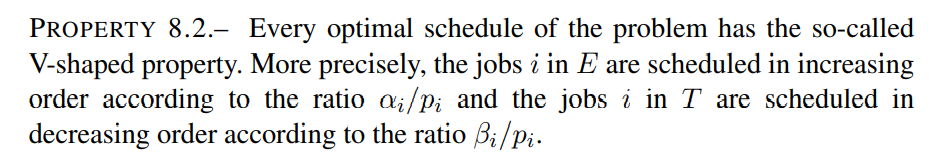

In [7]:
#data_df = pd.DataFrame(data=np.transpose([i_index, ai,bi,pi, ai/bi, bi/ai, (ai-bi), (ai-bi)/pi, (ai-bi)/(ai+bi), ((ai-bi)/(ai+bi))*pi  ]), columns=["i_index", "ai","bi","pi", "ai/bi", "ai/bi", "(ai-bi)", "(ai-bi)/pi", "z=(ai-bi)/(ai+bi)", "z*pi" ])

In [8]:
#data_df.sort_values(by="z*pi")